In [2]:
import sys
sys.path.append("../")
import libs.style
libs.style.styleme("../style/ipybn.style")

ImportError: No module named libs.style

In [8]:
%matplotlib qt
%matplotlib inline
import IPython
if IPython.__version__[0]=='2':
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('pdf','png')
    
#from matplotlib import rc_file
#rc_file('/usr/users/iff_th2/saggio/scripts/neutral.rc')'lines.linewidth':1,
import seaborn as sns
sns.set(style="white",context="poster")
#sns.set(style="white",context="paper",font="Liberation Serif",rc={'font.size': 15, 'font.family': 'serif',"figure.dpi":120,"axes.formatter.limits":(-2,2)})

#import libs.GG.xyzcodec as xyz

import matplotlib.pylab as pl
import numpy as np
import h5py
import glob
import tarfile
from string import atof

In [9]:
def mode_semiflex_freeBC(n,s):
    """
     return the normal mode for semiflexible and inextensible filaments with free BC as 
     compute  in  doi:10.1063/1.2753160 
     s must be simmetric in the arclenght interval [-L/2:L/2]
    """
    L=s.max()-s.min()
    
    ds=s[1]-s[0]
    
    if n==0:
        phi=np.sqrt(L**-1.)*(np.zeros(s.shape[0])+1.)
        norm=((phi**2).sum()*ds)**.5
        return phi/norm
    if n==1:
        phi=np.sqrt(L**-3.*12.)*s
        norm=((phi**2).sum()*ds)**.5
        phi/=norm
        phi-=phi.mean()
        return phi
    
    sh=np.sinh
    ch=np.cosh
    sn=np.sin
    cs=np.cos
    zeta=(2*n-1.)*np.pi/(2.*L)
    s=zeta*s
    sh2=sh(zeta*L/2)
    ch2=ch(zeta*L/2)
    sn2=sn(zeta*L/2)
    cs2=cs(zeta*L/2)
    
    
    if n%2:
        #odd
        phi= np.sqrt(L**-1.)*(sh(s)/sh2 + sn(s)/sn2)
    else:
        #even
        phi= np.sqrt(L**-1.)*(ch(s)/ch2 + cs(s)/cs2)
        
    norm=((phi**2).sum()*ds)**.5
    phi/=norm
    phi-=phi.mean()
    return phi


def scalar(p,mode):
    """
    returns the scalar product betwen a filament shape and the eigenmodes computed in doi:10.1063/1.2753160 
    it expects p.shape=[#numparticles,#numdimensions] 
    it return [#numdimensions] 
    for a graphical comparison, you have to subtract the cm position
    """
    #p=np.copy(p)
    #p-=p.mean(axis=0)
    if len(p.shape)==2:
        beads=p.shape[0]
        ds=(np.diff(p,axis=0)[0]**2).sum()**.5
    else:
        beads=p.shape[1]
        ds=(np.diff(p,axis=1)[0]**2).sum()**.5
    
    dx=0.001
    s=np.arange(-beads/2+1,beads/2+1,dx,dtype=np.float64)*ds
    phi=mode_semiflex_freeBC(mode,s)
    
    #print p.shape,phi.shape,phi[np.newaxis,::int(1/dx),np.newaxis].shape
    
    if len(p.shape)==2:
        return s[::int(1/dx)],((p-p.mean(axis=0))*phi[::int(1/dx),np.newaxis]).sum(axis=0)*ds
    elif len(p.shape)==3:
        phi=phi[np.newaxis,::int(1/dx),np.newaxis]
        return s[::int(1/dx)],((p-p.mean(axis=1)[:,np.newaxis,:])*phi).sum(axis=1)*ds

def filament_length(p):
    return ((np.diff(p,axis=0)**2).sum(axis=1)**.5).sum()

def unique_legend(ax,twin=None,man_sort=0,**kwargs):
    """
    in the case of man_sort=1 the function expects that the first caratchter of the label
    is there only to force a particular sorting, and that it has be removed from the printed label
    """
    
    handles,labels=ax.get_legend_handles_labels()
    if twin:
        _1,_2=twin.get_legend_handles_labels()
        
        handles.extend(_1)
        labels.extend(_2)
    k=dict(zip(labels,handles))
    labels=sorted(set(labels))
    handles=[k[l] for l in labels]
    if man_sort:
        labels=[i[1:] for i in labels]
    ax.legend(handles,labels,**kwargs)
    
def tosortedarray(a):
    a=np.array(a)
    idxx=np.argsort(a[:,0])
    
    return a[idxx]

def filament_length(p):
    return ((np.diff(p,axis=0)**2).sum(axis=1)**.5).sum()

def ittsplit(q,step,ev=1):
    for j in xrange(q.shape[1]/step):
        yield q[::ev,j*step:(j+1)*step]

def vscalar(p,mode):
    """
    returns the scalar product betwen a filament shape and the eigenmodes computed in doi:10.1063/1.2753160 
    it expects p.shape=[#numparticles,#numdimensions] 
    it return [#numdimensions] 
    for a graphical comparison, you have to subtract the cm position
    thisi is the vectorized version p.shape[time,#npart,#ndim]
    """
    #p=np.copy(p)
    #p-=p.mean(axis=0)
    if len(p.shape)==2:
        beads=p.shape[0]
        ds=(np.diff(p,axis=0)[0]**2).sum()**.5
    else:
        beads=p.shape[1]
        ds=(np.diff(p,axis=1)[0]**2).sum()**.5
    
    dx=0.001
    s=np.arange(-beads/2+1,beads/2+1,dx,dtype=np.float64)*ds
    phi=mode_semiflex_freeBC(mode,s)
    
    #print p.shape,phi.shape,phi[np.newaxis,::int(1/dx),np.newaxis].shape
    
    if len(p.shape)==2:
        return s[::int(1/dx)],((p-p.mean(axis=0))*phi[::int(1/dx),np.newaxis]).sum(axis=0)*ds
    elif len(p.shape)==3:
        phi=phi[np.newaxis,::int(1/dx),np.newaxis]
        return s[::int(1/dx)],(((p-p.mean(axis=1)[:,np.newaxis,:])*phi).sum(axis=1)*ds).T

In [10]:
s=np.arange(-.5,.5+.01,.01)

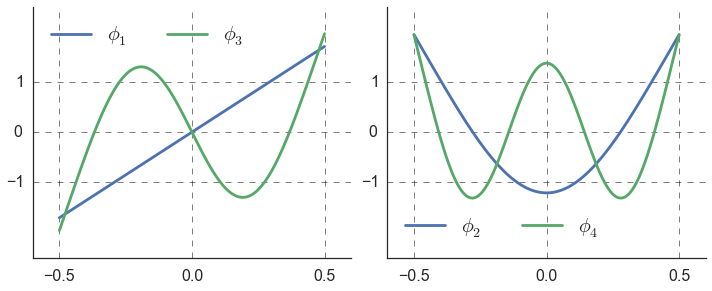

In [11]:
fig,(a,b)=pl.subplots(1,2,figsize=(12/1.2,5/1.2))


for  n in [1,3]:
    y=mode_semiflex_freeBC(n,s)
    a.plot(s,y,label="$\phi_%d$" % n)
    y=mode_semiflex_freeBC(n+1,s)
    b.plot(s,y,label="$\phi_%d$" % (n+1))

for j in (a,b):
    j.yaxis.set_ticks([-1,0,1])
    j.xaxis.set_ticks([-.5,0,.5])
    j.set_xlim(-.6,.6)
    j.set_ylim(-2.5,2.5)
    j.legend(ncol=2,loc=0,fontsize=20)
    j.grid(c='k',lw=.5,ls='--')
    
fig.tight_layout()
sns.despine()
fig.savefig("biharm_modes.pdf",bbox_inches="tight")

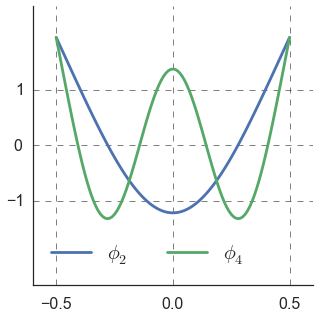

In [14]:
fig,a=pl.subplots(1,1,figsize=(5/1.1,5/1.1))


for  n in [1,3]:
#     y=mode_semiflex_freeBC(n,s)
#     a.plot(s,y,label="$\phi_%d$" % n)
    y=mode_semiflex_freeBC(n+1,s)
    a.plot(s,y,label="$\phi_%d$" % (n+1))

for j in (a,):
    j.yaxis.set_ticks([-1,0,1])
    j.xaxis.set_ticks([-.5,0,.5])
    j.set_xlim(-.6,.6)
    j.set_ylim(-2.5,2.5)
    j.legend(ncol=2,loc=0,fontsize=20)
    j.grid(c='k',lw=.5,ls='--')
    
fig.tight_layout()
sns.despine()
fig.savefig("biharm_modes_1.pdf",bbox_inches="tight")